#### Self-Driving Car Engineer Nanodegree - Deep Learning Project

---

## Traffic Sign Recognition Classifier

---

In addition to implementing code, there will be questions which relate to the project and implementation. 


#### Environment set up 

In [1]:
import os
from csv import DictReader
import random
import numpy as np
from skimage import exposure
from skimage.color import rgb2gray
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Visualizations will be shown in the notebook.
%matplotlib inline

np.random.seed(58) # Maintain coherence among trials

---
## Step 0:  Load the data

The model is based on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test,  y_test  =  test['features'],  test['labels']

---

## Step 1:  Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### The German Traffic Signs Dataset

In [3]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Find the shape of a traffic sign image
image_shape = X_test.shape[1:]

# Find unique classes/labels in the dataset.
n_classes = len(set(train.get('labels')))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Look at the data

In [4]:
# Given a csv file with fieldnames in the top row
with open('signnames.csv') as csvfile:
    reader = DictReader(csvfile)   
    img_legend = {}    
    for row in reader:
        img_legend[row[reader.fieldnames[0]]]= row[reader.fieldnames[1]]  

print ("MEMO: SIGNALS IN PICTURES\n")
print ("Label_id    Signal\n")

for value in sorted(img_legend.values()):
    for label_id, signal in img_legend.items():
        if signal == value:
            print (" ",label_id.rjust(2),"     ", value)

MEMO: SIGNALS IN PICTURES

Label_id    Signal

  35       Ahead only
  30       Beware of ice/snow
  29       Bicycles crossing
  22       Bumpy road
  28       Children crossing
  19       Dangerous curve to the left
  20       Dangerous curve to the right
  21       Double curve
  32       End of all speed and passing limits
  41       End of no passing
  42       End of no passing by vehicles over 3.5 metric tons
   6       End of speed limit (80km/h)
  18       General caution
  37       Go straight or left
  36       Go straight or right
  39       Keep left
  38       Keep right
  17       No entry
   9       No passing
  10       No passing for vehicles over 3.5 metric tons
  15       No vehicles
  27       Pedestrians
  12       Priority road
  11       Right-of-way at the next intersection
  24       Road narrows on the right
  25       Road work
  40       Roundabout mandatory
  23       Slippery road
   7       Speed limit (100km/h)
   8       Speed limit (120km/h)
   0     

### Frequency distribution of sign labels

 

                   FREQUENCY DISTRIBUTION OF SIGN LABELS



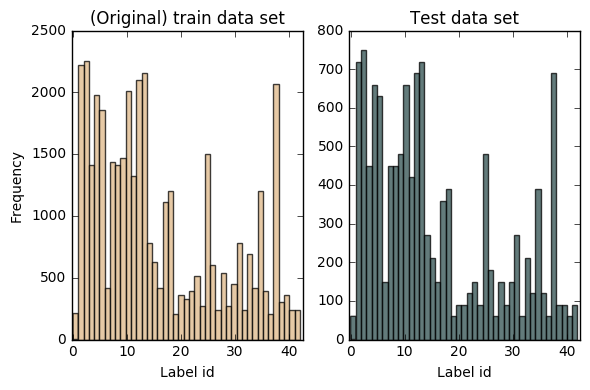

In [5]:
# Check the number of examples per label

# Look at the sign frequency distribution
# and plot two different histograms, for the train and the data sets

# Train data set - frequency distribution
plt.subplot(121)
plt.hist(y_train, n_classes, normed=0, facecolor='burlywood', alpha=0.75)
plt.xlabel('Label id')
plt.ylabel('Frequency')
plt.title('(Original) train data set')
plt.axis([-0.25, n_classes-.5, 0,2500])
plt.grid(False)

# Test data set - frequency distribution
plt.subplot(122)
plt.hist(y_test, n_classes, normed=0, facecolor='darkslategray', alpha=0.75)
plt.xlabel('Label id')
plt.title('Test data set')
plt.axis([-0.25, n_classes-.5, 0,800])
plt.grid(False)

plt.tight_layout()
print (" \n")
print("                   FREQUENCY DISTRIBUTION OF SIGN LABELS\n")
plt.show()

**Notes:**  

>Plots show a huge diversity in tne number of examples per classes: the training data set should be better balanced (uniformly distributed).  

>To tackle this issue, I should increase the number the unfrequent sign images: oversampling them, by adding new images or finally by adding partially modified images taken from the given training dataset (such modification includes rotation or modifying color intensity, darkness and brightness, blurring them, increasing their contrast, etc.). 

----

## Step 2: Design and Test a Model Architecture

In design and implementing a deep learning model that learns to recognize traffic signs, there are various aspects to consider:  

- Neural network architecture
- Preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).  


### Preprocessing

In [6]:
# Preprocessing functions

def rescale_img(rgb_img): 
    '''
    Tranform a rgb image into a moderae high contrast gray image
    INPUT: rgb_img, an image array of the same format of train and test datasets
    OUTPUT: the same array in gray version (last dimension omitted). 
    '''
    # Convert rgb_img to gray scale
    gray = 0.2125 * rgb_img[...,0] + 0.7154 * rgb_img[...,1] + 0.0721 * rgb_img[...,2]
    
    # Select a centered section of the image
    # For rescaling, use only the middle of the image (where usually the signal lays)
    start = 8; end = 25
    center_gray = gray[:,start:end,start:end]
    
    # Percentiles of centered image(s)
    p5,p95 = np.percentile(center_gray,[5,95],axis=[1,2],overwrite_input=True)
    
    # Contrast stretching: rescale every gray image
    out=[]
    for i in range(len(gray)):
        out.append(exposure.rescale_intensity(np.asarray(gray[i,:]),in_range=(p5[i], p95[i])))
    return  np.asarray(out)

# Preprocess datasets: output values stay between -1 and +1
# Train X dataset
rescaled_original_X_train = np.expand_dims(rescale_img(X_train), axis=3) 
# Test X dataset
rescaled_x_test = np.expand_dims(rescale_img(X_test), axis=3) 

print("\n*** Gray-rescaled train data shape =", rescaled_original_X_train.shape, "***")
print("*** Gray-rescaled test data shape  =", rescaled_x_test.shape, "***\n")
print("Data preprocessing done.")


*** Gray-rescaled train data shape = (39209, 32, 32, 1) ***
*** Gray-rescaled test data shape  = (12630, 32, 32, 1) ***

Data preprocessing done.


### Images visualization

In [7]:
# Show images in their original version and after the modification incurred 
# during the preprocessing step (for both original training and test sets)
# Images are also qualified with their sign name

def plot_img(img,gray,rescaled):   
    ''' 
    Show rgb (original) images, their gray version and 
    contrast enanced images (that will act as input of the neural network)
    '''
    
    plt.subplot(131); plt.xticks([]), plt.yticks([])
    plt.imshow(img) 
    plt.subplot(132); plt.xticks([]), plt.yticks([])
    plt.imshow(gray, cmap='gray')
    plt.subplot(133); plt.xticks([]), plt.yticks([])
    plt.imshow(rescaled, cmap='gray')
    plt.show()
    
    
def show_preprocessing (sample_size=5,test_set=False):
    '''
    Shows some pictures chosen randomly from the training (default) or 
    from the test data sets. 
    Shows also their gray version and the result of the preprocessing.
     
    '''
    
    for i in range(sample_size):
        if(test_set):
            img_set = 'test'
            # select a random number to index a test set image 
            rnd_img = random.randint(0, n_test-1)
            # get the image
            img = test['features'][rnd_img:rnd_img+1]
            # get its label
            label_idx = test['labels'][rnd_img] 
            gray = rgb2gray(img[0])
            rescaled = rescaled_x_test[rnd_img,:,:,0]
        else:
            img_set = 'training'
            # select a random number to index an image from the training set 
            rnd_img = random.randint(0, n_train-1)
            # get the image
            img = train['features'][rnd_img:rnd_img+1]
            # get its label
            label_idx = train['labels'][rnd_img]
            gray = rgb2gray(img[0])
            rescaled = rescaled_original_X_train[rnd_img,:,:,0]
            
        # print sign name ad show images
        print(' ')
        print ('Sample picture from',img_set, 'set:',img_legend[str(label_idx)])
        print ('[ Image #',rnd_img,', class #',label_idx,']' ,)
        
        plot_img(img[0],gray,rescaled)


 
 *** ORIGINAL, GRAY and CONTRAST ENHANCED IMAGES ***
 
 
Sample picture from training set: Keep right
[ Image # 37960 , class # 38 ]


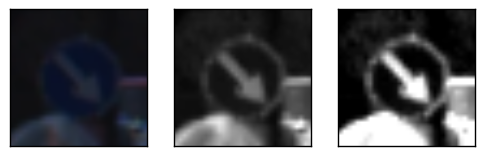

 
Sample picture from training set: Wild animals crossing
[ Image # 32441 , class # 31 ]


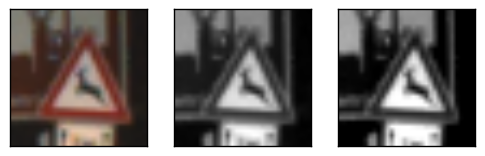

 
Sample picture from training set: Yield
[ Image # 20812 , class # 13 ]


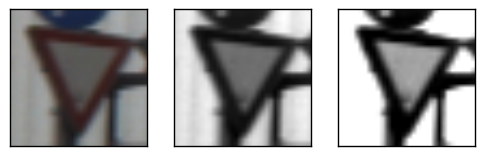

 
Sample picture from training set: General caution
[ Image # 25324 , class # 18 ]


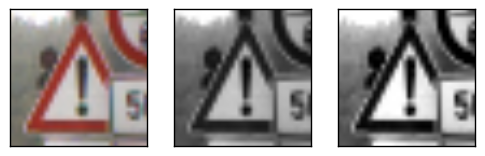

 
Sample picture from training set: Speed limit (80km/h)
[ Image # 8793 , class # 5 ]


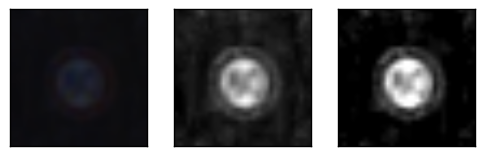

 
Sample picture from test set: Right-of-way at the next intersection
[ Image # 10763 , class # 11 ]


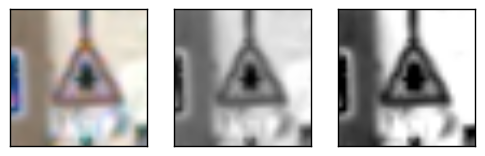

 
Sample picture from test set: Wild animals crossing
[ Image # 8228 , class # 31 ]


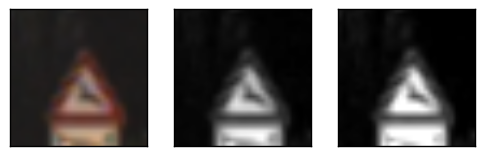

 
Sample picture from test set: Speed limit (30km/h)
[ Image # 12213 , class # 1 ]


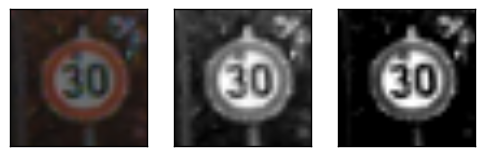

 
Sample picture from test set: No passing for vehicles over 3.5 metric tons
[ Image # 985 , class # 10 ]


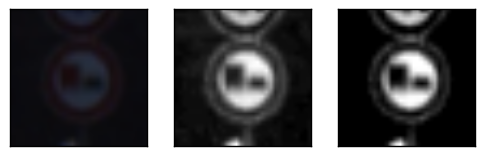

 
Sample picture from test set: Speed limit (70km/h)
[ Image # 6531 , class # 4 ]


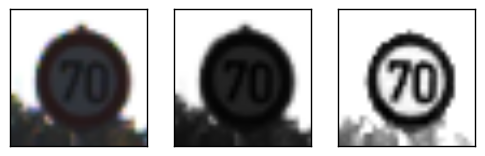

In [8]:
# Show examples of the images preprocessing step
print(' ')
print (' *** ORIGINAL, GRAY and CONTRAST ENHANCED IMAGES ***')
print(' ')
        
# For the training data set
show_preprocessing ()

# For the test data set
show_preprocessing (test_set=True)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer 1**

>Images in the dataset are different in quality. Moreover, neural networks prefer their inputs to be normalized.  

>As a first step, I convert color images into their grayscale version. 

>Then, in order to promote the area that usully contains the sign, the code performs a gray rescaling process using only the area in the center of the image. In other words, instead of using the entire 32x32 image, in the reascaling phase I select a 16x16 square just in the middle of the image.

>This kind of selection allows a more clear representation of the road sign, even for dark, blurred or low-resolution images. I think that this should help to better differentiate among images. 

>The shape of the final images dataset - that will act as imput of the neural network - is (?, 32, 32, 1).  
The corresponding images values lie in the interval [0,1] (instead of [0-255]).




### Training/validation/testing sets split

In [9]:
def train_divide(X_train,y_train,n_train,n_test):
    '''
    Extract a validation set from the training set. 
    Set the validation set size equal to a fixed number (here the test size).
    
    INPUT:  X_train  - the training data set to split
            y_train  - its associted labels
            n_train  - training sample dimension
            n_test   - target dimension for the validation set
    OUTPUT: x_train      - the training set
            train_labels - training set labels
            x_valid      - the validation set
            valid_labels - validation set labels
           
    '''

    # Set the number of examples in the validation set
    n_valid = n_test
    # Set the number of examples in the training set
    n_training = n_train - n_valid

    # Shuffle and extract the two sets
    shuffled_indices = np.random.permutation(np.arange(n_train))
    
    idx = shuffled_indices[np.arange(n_valid,n_train)]   
    x_train      = X_train [idx]
    train_labels = y_train [idx]
    
    idx = shuffled_indices[np.arange(n_valid)]
    x_valid      = X_train [idx]
    valid_labels = y_train [idx]
    
    return x_train, train_labels, x_valid, valid_labels

In [10]:
np.random.seed(57) # Maintain coherence among trials

# Extract the validation set from the training set. 
rescaled_x_train,train_labels,rescaled_x_valid,valid_labels = train_divide(rescaled_original_X_train,y_train,n_train,n_test)

print('\n            DATA-SETS DIMENSIONS\n')
print('                      Images        Labels')
print('Training set  :', rescaled_x_train.shape, train_labels.shape)
print('Validation set:', rescaled_x_valid.shape, valid_labels.shape)
print('Test set      :',  rescaled_x_test.shape,       y_test.shape)
print('\n')


#del X_test, X_train, rescaled_original_X_train


            DATA-SETS DIMENSIONS

                      Images        Labels
Training set  : (26579, 32, 32, 1) (26579,)
Validation set: (12630, 32, 32, 1) (12630,)
Test set      : (12630, 32, 32, 1) (12630,)




### Additional data set summary

 

                   FREQUENCY DISTRIBUTION OF SIGN LABELS
                    (in train and validation data sets)



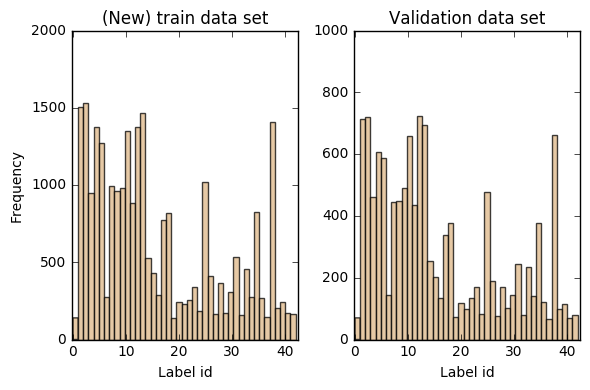

In [11]:
# Have a look of signal frequency distribution
# for the (new) train and validation data set

# Train data set
plt.subplot(121)
n, bins, patches = plt.hist(train_labels, n_classes, normed=0, facecolor='burlywood', alpha=0.75)
plt.xlabel('Label id')
plt.ylabel('Frequency')
plt.title('(New) train data set')
plt.axis([-0.25, n_classes-.5, 0,2000])
plt.grid(False)

#Validation data set
plt.subplot(122)
n, bins, patches = plt.hist(valid_labels, n_classes, normed=0, facecolor='burlywood', alpha=0.75)
plt.xlabel('Label id')
plt.title('Validation data set')
plt.axis([-0.25, n_classes-.5, 0,1000])
plt.grid(False)

plt.tight_layout()
print (" \n")
print("                   FREQUENCY DISTRIBUTION OF SIGN LABELS")
print("                    (in train and validation data sets)\n")
plt.show()


In [12]:
# Encode signal integer labels in their one-hot version
# before passing them to the model

onehot_classes = np.array(range(n_classes))

def oneHot(dummy_labels,onehot_classes):
    le = preprocessing.LabelEncoder()
    enc = OneHotEncoder(n_values=len(onehot_classes))
    le.fit (onehot_classes)   
    y_dummy = le.transform(dummy_labels)
    y_dummy = y_dummy.reshape(-1, 1)
    enc.fit(y_dummy)
    y_dummy = enc.transform(y_dummy).toarray()
    y_dummy = y_dummy.astype('float32')
    return y_dummy
        
y_train_oh = oneHot(train_labels,onehot_classes)
y_valid_oh = oneHot(valid_labels,onehot_classes)
y_test_oh  = oneHot(y_test,onehot_classes)

In [13]:
print('\n            DATA-SETS DIMENSIONS\n')
print('                      Images        One-hot encoded labels')
print('Training set  :', rescaled_x_train.shape,y_train_oh.shape)
print('Validation set:', rescaled_x_valid.shape,y_valid_oh.shape)
print('Test set      :',  rescaled_x_test.shape,       y_test_oh.shape)
print('\n')


            DATA-SETS DIMENSIONS

                      Images        One-hot encoded labels
Training set  : (26579, 32, 32, 1) (26579, 43)
Validation set: (12630, 32, 32, 1) (12630, 43)
Test set      : (12630, 32, 32, 1) (12630, 43)




### Question 2

_Describe how you set up the training, validation and testing data for your model._ 

**Answer 2**   

>The original number of training examples is 39,209 and the number of testing examples is 12,630. Now, I split the original train set in two different sets: a new training set and a validatin set.

>Setting the validation set size to the value of 12,630 (i.e. to a value equal to the test set size), I can obtain (more or less) the following proportions, that seem suitable for this classification task:

>Training - Validation - Test: (50-25-25) %... of the entire sample  
Training - Validation: (66.6-33.3) %... of the training set  
         
>Just before the splitting process, I shuffle the data in order to increase the randomness of the process.   
Finally, once defined the three X data sets, I also one-hot encode their Y labels. 

### Model Architecture

In [14]:
# Create the model
def LeNet(x):
    
    # Layer 1
    depth1 = 80
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, depth1)))
    conv1_b = tf.Variable(tf.zeros(depth1))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2
    depth2 = 120
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, depth1, depth2)))
    conv2_b = tf.Variable(tf.zeros(depth2))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
    # Flatten
    fc1 = flatten(conv2) 
    depth3 = 200
    
    # Layer 3 (fully connected)
    fc1_shape = (fc1.get_shape().as_list()[-1], depth3)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc1_shape)))
    fc1_b = tf.Variable(tf.zeros(depth3))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)

    # Output
    fc2_W = tf.Variable(tf.truncated_normal(shape=(depth3, 43)))
    fc2_b = tf.Variable(tf.zeros(43))
    return tf.matmul(fc1, fc2_W) + fc2_b


In [15]:
# Ancilary routines for running the estimation

def batch_iter(data, shuffle=True):
    ''' Generates a batch iterator for a dataset.'''
    
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(data_size/BATCH_SIZE) + 1
        
    # Shuffle the data at each epoch
    if shuffle:
        shuffled_indices = np.random.permutation(np.arange(data_size))
        shuffled_data = data[shuffled_indices]
    else:
        shuffled_data = data
            
    for batch_num in range(num_batches_per_epoch):
        start_index = batch_num * BATCH_SIZE
        end_index = min((batch_num + 1) * BATCH_SIZE, data_size)
        yield shuffled_data[start_index:end_index]
            

def eval_dataset(x_data,y_data,setlabel="Eval."):    
    '''
    Print and returns loss and accuracy for a given dataset.
    INPUT:  the dataset {x_data,y_data}
            setlabel - character label to be printed for specifying the kind of data set involved 
            (training, validation, test set). 
    '''
        
    # Generate batches
    batches = batch_iter(list(zip(x_data, y_data)))
    
    total_acc, total_loss = 0, 0   
    n_batch = 0
    num_examples = 0

    # Training loop. For each batch...
    for batch in batches:
        n_batch +=1   
        batch_x, batch_y = zip(*batch) 
        
        num_examples += len(batch_y) # len of the last batch could be less than batch_size
        loss, acc = sess.run([loss_op, accuracy_op],
                             feed_dict={x: batch_x, y: batch_y}) 
        total_acc  += (acc  * len(np.array(batch_x)))
        total_loss += (loss * len(np.array(batch_x)))
        
    
    # displaying results
    print("--",setlabel, "( images:",num_examples,")",
          "-- Sample (batches): {} ...".format(n_batch),
          "loss = {:.3f}".format(total_loss/num_examples),
          "accuracy = {:.3f}".format(total_acc/num_examples) )
    print()
                    
    return total_loss/num_examples, total_acc/num_examples


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432)._


**Answer 3**

>The architecture is based on a LeNet-5 (for digits) structure.   
This is a good plug and play starting point, also because of the presence of digits in several road-signs (i.e. speed limits). 

>This (Modified) LeNet architecture can be represented as:  
*INPUT -> CONV1 -> ACT1 -> POOL1 -> CONV2 -> ACT2 -> POOL2 -> FLATTEN -> FC1 -> ACT3 -> FC2*  

>Where:  
>* INPUT <- 32x32 pixel images  
  
>* CONV1 <- Convolutional neural network (CNN), shape 5x5, strides 1 (padding VALID), depth 80: shape=(?, 28, 28, 80)    
>* ACT1  <- ReLu: shape=(?, 28, 28, 80)     
>* POOL1 <- Max pooling, size 2, strides 2 (padding VALID): shape=(?, 14, 14, 80)  
  
>* CONV2 <- Convolutional neural network (CNN), shape 5x5, strides 1 (padding VALID), depth 120: shape=(?, 10, 10, 120)   
>* ACT2  <- ReLu: shape=(?, 10, 10, 120)   
>* POOL2 <- Max pooling, size 2, strides 2 (padding VALID): shape=(?, 5, 5, 120)   

>* FLATTEN <- flatten POOL2 (1D instead of 3D - i.e. 5x5x120 ): shape=(?, 3000)

>* FC1 <- Fully connected layer 1: shape=(?, 200)  
>* ACT3 <- ReLu: shape=(?, 200)   

>* FC2 <- Fully connected layer 2: shape=(?, 43)


### Training parameters

In [16]:
BATCH_SIZE = 128 
TRAINING_EPOCHS = 21 

### Training architecture

In [17]:
np.random.seed(58) # Maintain coherence among trials

# Input data consist of 32x32x1, rescaled grayscale images
# Classes are one-hot encoded
x = tf.placeholder(tf.float32, [None, rescaled_x_train.shape[1],rescaled_x_train.shape[2],1])
y = tf.placeholder(tf.float32, [None, n_classes])

# Apply the model to obtain logits
logits = LeNet(x)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
opt = tf.train.AdamOptimizer()
train_op = opt.minimize(loss_op)

# Check predictions
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))

# Calculate accuracy
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 


### Tensorflow design

In [18]:
# Tensorflow session 

# Some info before starting 
total_batch = int(rescaled_x_train.shape[0]/BATCH_SIZE) + 1
print("Memo:")
print("Training epochs",TRAINING_EPOCHS)
print("Batches per epoch",total_batch)
print(" ")
    
# Initializing the variables
init = tf.initialize_all_variables()

#Instead of "with tf.Session() as sess:", but requires a later "sess.close()"
sess = tf.Session()
sess.run(init)    
       
for epoch in range(TRAINING_EPOCHS):
    print("Epoch",epoch+1)
                 
    # Generate batches
    batches = batch_iter(list(zip(rescaled_x_train, y_train_oh)))
        
    # Training loop. For each batch...
    batch_idx = 0
    for batch in batches:
        batch_idx += 1
        batch_x, batch_y = zip(*batch)
        loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y})
        train_loss, train_acc = sess.run([loss_op, accuracy_op],
                                         feed_dict={x: batch_x, y: batch_y}) 
            
        if(np.mod(batch_idx,50)==0):
            print("-- Train",
                  "-- Batch # {} ...".format(batch_idx),
                  "loss = {:.3f}".format(train_loss),
                  "accuracy = {:.3f}".format(train_acc) )
    val_loss, val_acc = eval_dataset(rescaled_x_valid,y_valid_oh)  
    
test_loss, test_acc = eval_dataset(rescaled_x_test,y_test_oh,setlabel="TEST:")        
            
print()
print("Optimization ended")

Memo:
Training epochs 21
Batches per epoch 208
 
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 1
-- Train -- Batch # 50 ... loss = 7927.516 accuracy = 0.180
-- Train -- Batch # 100 ... loss = 4878.841 accuracy = 0.336
-- Train -- Batch # 150 ... loss = 2755.044 accuracy = 0.438
-- Train -- Batch # 200 ... loss = 1835.894 accuracy = 0.594
-- Eval. ( images: 12630 ) -- Sample (batches): 99 ... loss = 2148.193 accuracy = 0.536

Epoch 2
-- Train -- Batch # 50 ... loss = 1649.374 accuracy = 0.633
-- Train -- Batch # 100 ... loss = 1297.074 accuracy = 0.656
-- Train -- Batch # 150 ... loss = 897.009 accuracy = 0.695
-- Train -- Batch # 200 ... loss = 1487.155 accuracy = 0.609
-- Eval. ( images: 12630 ) -- Sample (batches): 99 ... loss = 1034.712 accuracy = 0.683

Epoch 3
-- Train -- Batch # 50 ... loss = 943.348 accuracy = 0.672
-- Train -- Batch # 100 ... loss = 819.872 accuracy = 0.805
-- Train -- Batch # 150 ... loss = 657.687 accuracy = 0.789
-- Train --

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


#### **Answer 4**

>This modified version of the LeNet-5 model uses the Adam optimizer algorithm (Kingma and Ba, 2014). This algorithm is based on adaptive estimates of lower-order moments; it is computationally efficient, also in terms of memory requirements. 

>I divide the training set in batches of size 128: the model runs (slowly, bt runs) even with the CPU of an old MacBook Pro [4 GB- 2.4 GHz Intel Core i5 - 4 GB]. At every epoch, I reshuffle the data before creating batches.

>As a general guideline, I try to avoid bottlenecks, especially in the first layers. 
>In the model architecture, all parameters and hyperparameters are set to avoid overfitting and to produce a quite slow increase of the accuracy for the training set. Moreover, the  rate of the increase of the accuracy of the evaluation set must grow in parallel. 

>Losses should follow a similar pattern, decreasing in a coherent way.

>To monitor train and validation, I ask for the evaluation of loss and accuracy of the training set every 50 batches and for the evaluation of loss and accuracy of evaluation set once per epoch. A log of the proceeding shows this particular quality. 

>The test set is used once at the end of the estimation process.

>I didn't set the number of epochs a priori, but it is the result of the approach taken. 

>After a dozen of epochs the (sampled) train accuracy and the validation accuracy start slowly diverging, but the growth of the accuracy for the validation test remains tangible and I evaluate that at the end of the process the overfitting is still very low.

>At the end, I obtain the following results:  
>* train set accuracy is near 100%, 
>* the validation set accuracy is about 94% 
>* the test accuracy is about 85%.


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer 5**  

>I started from a plain LeNet-5 model and then I modified one aspect at the time, trying different options. 

>The first task was the choice of the optimizer and then I increased/decreased the number of layers, I changed the activation functions, the convolution parameters, etc. Anyway, going far away from the canonical LeNet framework didn't yield very much. 

>A great part of the job was dedicated to struggle the incoming overfitting and gaining results with a limited number of epochs. I found that the easiest way to manage the performance of the model was by modifying the depth of the layers; I tried a lot of different combinations.

>The second rule I used was: when the validation accuracy stops increasing then stop the runs: the number of epochs is a consequence of this rule.

> _I tried to set a model that squeezes the training set to an accuracy near 1 and nonetheless allows a growth of the validation set accuracy_.  

>All the times it was difficult to perform well for both validation and test set, probably for the different quality of the images of the two datasets. 


---

## Step 3: Test a Model on New Images


### Load and plot new images

#### Note: 
> New images labels are coded somewhere in the name of the .png file.    

> E.g., the image **NZ_South_2_Makikihi.png** represents a _Speed limit (50km/h)_ road sign (placed in Makikihi, NZ) - being **"2"** the _Speed limit (50km/h)_ identifier.

In [19]:
def load_new_images(path):
    ''' Return an array of images, togheter with their labels.
        INPUT: the path directory, containing only images (32x32) .
        OUTPUT: an array of loaded images togheter with their labels (integer)
    '''
    # Select the directory path
    image_list = os.listdir (path)
    
    # Set to zero outputs
    loaded_images = np.zeros((len(image_list),32,32,3))
    loaded_labels= np.zeros((len(image_list),), dtype=np.int)

    idx = 0
    for image in image_list:
        filename = os.path.join(path,image)
        loaded_images[idx,...]= mpimg.imread(filename)  
        
        # here get the label
        loaded_labels[idx] = int(''.join(list(filter(str.isdigit, image))))        
        idx +=1
    return loaded_images,loaded_labels
 

In [20]:
# Load the images
path = 'traffic-signs-my-five-images'
loaded_X,loaded_labels = load_new_images(path)

#### Preprocess and plot new images

 
Sample picture from the new set: Speed limit (30km/h)
[ Image # 1 , class # 1 ]


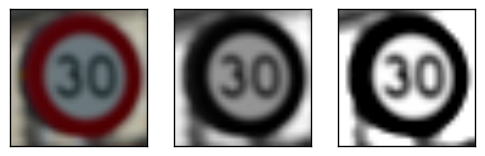

 
Sample picture from the new set: Yield
[ Image # 2 , class # 13 ]


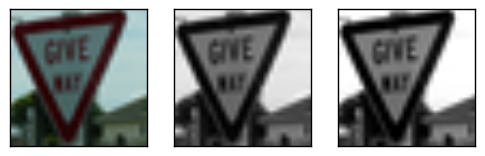

 
Sample picture from the new set: Speed limit (50km/h)
[ Image # 3 , class # 2 ]


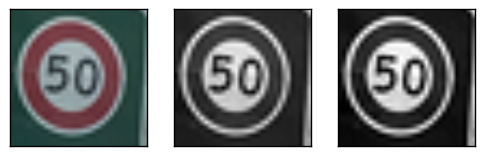

 
Sample picture from the new set: No entry
[ Image # 4 , class # 17 ]


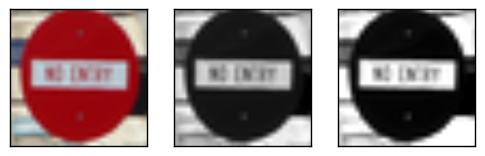

 
Sample picture from the new set: Speed limit (50km/h)
[ Image # 5 , class # 2 ]


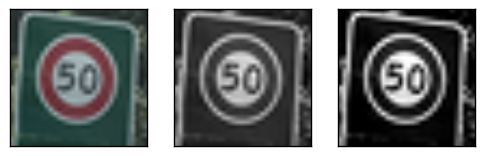

In [21]:
def preprocess_new_images(loaded_X,loaded_labels):
    '''Preprocess and displays the new images'''
    
    new_X = rescale_img(loaded_X)
    
    for i in range(loaded_X.shape[0]):
        gray = rgb2gray(loaded_X[i,...])
        print(' ')
        print ('Sample picture from the new set:',img_legend[str(loaded_labels[i,])])
        print ('[ Image #',i+1,', class #',loaded_labels[i,],']' ,)        
        plot_img(loaded_X[i],gray,new_X[i])
    
    return new_X[..., None]

# Run
new_X = preprocess_new_images(loaded_X,loaded_labels) 
new_Y = oneHot(loaded_labels, onehot_classes)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer 6**  
>I took some pictures of New Zealand's roads.  

>Road signs in New Zealand are different from those included in the German dataset. As an example, speed limits at the town entry have a double circle, instead of a simple red large border (see pictures 1 and 5). This aspect doesn't decrease the overall performance of the model: as shown below, it recognizes the pictures 1 and 5 equally well. 

>However, it seems that the variability in the area covered by the sign in the picture (i.e. the ratio [sign area size in pixels] / 1024) could impact, because for the German road signs dataset this ratio is quite stable. For an example, see images 3 and 5, taken from the same picture, where image 3 has an higher ratio: as we'll see below, my model doesn't detect the speed limit in image 3, but it does for image 5.

>Aside, while selecting road signs images from pictures I found that, surprisingly, a great number of pixels dedicated to the sign in the original picture decreases the quality of the road sign image once the reduction to a 32x32 pixel size is performed.

>Therefore, to obtain best reults - with the model I trained - images must be originally in a size near to the 32x32 and sign must occupy a portion similar to that of our German training set.  

In [22]:
### Run the predictions here.
# Verify the performance of the model on the new dataset
mytest_loss, mytest_acc = eval_dataset(new_X,new_Y,setlabel="Captured data")


-- Captured data ( images: 5 ) -- Sample (batches): 1 ... loss = 2117.654 accuracy = 0.400



### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_

#### **Answer 7**  

>With captured pictures, the model performs quite well, even if it's not able to reach the accuracy of the test sample. 
To obtiain performance indicators, I use the same routine already used in the previuos part of the project.  

>The reached accuracy level is 40%.  

In [23]:
### Visualize the softmax probabilities here.

In [24]:
# Define the softmax function 
def softmax(z):
    z -= np.max(z)
    return np.exp(z) / np.sum(np.exp(z))

In [25]:
# Set the number of the top k prediction
kTop = 5

for i in range(loaded_X.shape[0]):
    
    print("---------------------------------------------------------------------------------")
    print("Image #",i+1)
    print("---------------------------------------------------------------------------------")
    
    # Acquire logits value
    myLogit = sess.run([logits], feed_dict={x: new_X[i:i+1], y: new_Y[i:i+1]})
    
    # Apply softmax
    myLogitSoftmax = softmax(myLogit[0][0])
    print("Softmax:",myLogitSoftmax)
    
    # Apply tf.nn.top_k to obtain 
    # the values and indices (class ids) of the top k prediction  
    myTop= sess.run(tf.nn.top_k(tf.constant(np.array(myLogitSoftmax)), k=kTop))   
    
    
    print("\n*** Actual class:   ", loaded_labels[i],"->",img_legend[str(loaded_labels[i,])])
    print("*** Predicted class:", myTop.indices[0],"->", img_legend[str(myTop.indices[0] )])
    print("\n[ Top", kTop, "]", "-> Indices:", myTop.indices, "Prob:", myTop.values, )
    print(" ")
    print(" ")

---------------------------------------------------------------------------------
Image # 1
---------------------------------------------------------------------------------
Softmax: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]

*** Actual class:    1 -> Speed limit (30km/h)
*** Predicted class: 1 -> Speed limit (30km/h)

[ Top 5 ] -> Indices: [1 0 2 3 4] Prob: [ 1.  0.  0.  0.  0.]
 
 
---------------------------------------------------------------------------------
Image # 2
---------------------------------------------------------------------------------
Softmax: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.]

*** Actual class:    13 -> Yield
*** Predicted class: 40 -> Roundabout mandatory

[ Top 5 ] -> Indices: [40  0  1  2  3

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer 8**  

>In the examples above, the softmax probablity always reaches the value of 1 for only one class (other values being equal to 0).

>In this cases, "tf.nn.top_k" ranks and displays the classes after the top one in an alphabetical order (e.g. 0,1,2,3..). These classes can not be considered as the best prediction after the top one, even if the actual class appears in such list. As an example, see the "tf.nn.top_k" for image 3: the actual class is 2 and this value is an output of "tf.nn.top_k", but the related softmax is zero.

>Therefore, in the above examples, in every event the model is incorrect in its initial prediction, the correct prediction doesn't belong to the top k (for every k>1).


In [26]:
# At the end, close the Tensorflow session
sess.close()